# Reviews

## Librairies

In [287]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import os
from os.path import exists
import pickle
import json
from datetime import datetime
import timeit
import nltk
import urllib
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import string
from gensim.corpora import Dictionary
from gensim.models import LdaModel, Word2Vec
from gensim.models import TfidfModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import utils
import dask.dataframe as dd
from dask.distributed import Client
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn import preprocessing
from sklearn.manifold import TSNE
from textblob import TextBlob

## Settings

In [288]:
plt.style.use('dark_background')
pd.set_option("max_rows", None)
pd.set_option("max_columns", None)
pio.renderers.default='notebook'

## Constantes

In [289]:
RERUN_ALL = False
FILENAME_REVIEWS = "data/yelp_academic_dataset_review.json"
sav_path = "./sav/"
dashboard_prefix = "DASH_"

## Chargement des données et échantillonnage

In [290]:
def import_and_sample_bad_reviews(
    path, 
    nb_sample, 
    plot=False, 
    verbose=False,
    random_state=1
):
    path = "./{}".format(path)
    if verbose: 
        print("Importation des reviews depuis {}".format(path))
    reviews = pd.read_json(path, lines=True)
    if verbose:
        print("{} reviews importées".format(reviews.shape[0]))
    if plot:
        plt.figure(figsize=(18,9))
        ax = sns.countplot(
            data = reviews,
            x = "stars"
        )
        ax.bar_label(ax.containers[0])
        ax.set_title("répartition des reviews par note (avant échantillonage)")
        plt.show()
    if verbose:
        print("Récupération des reviews dont la note est inférieure à 3 étoiles...")
    reviews = reviews[reviews["stars"] < 3]
    if verbose:
        print("{} mauvaises reviews récupérées")
        print("Echantillonage de {} reviews...".format(nb_sample))
    reviews = reviews.sample(n=nb_sample, random_state=random_state)
    if verbose:
        display(reviews.head())
        print("Echantillonage OK. Nombre de reviews : {}".format(reviews.shape[0]))
    if plot:
        plt.figure(figsize=(18,9))
        ax = sns.countplot(
            data = reviews,
            x = "stars"
        )
        ax.bar_label(ax.containers[0])
        ax.set_title("répartition des reviews par note (après échantillonage)")
        plt.show()
    return reviews

def import_and_sample_reviews(
    path, 
    nb_sample, 
    plot=False, 
    verbose=False,
    random_state=1
):
    path = "./{}".format(path)
    if verbose: 
        print("Importation des reviews depuis {}".format(path))
    reviews = pd.read_json(path, lines=True)
    if verbose:
        print("{} reviews importées".format(reviews.shape[0]))
    if plot:
        plt.figure(figsize=(18,9))
        ax = sns.countplot(
            data = reviews,
            x = "stars"
        )
        ax.bar_label(ax.containers[0])
        ax.set_title("répartition des reviews par note (avant échantillonage)")
        plt.show()
    if verbose:
        print("Echantillonage de {} reviews...".format(nb_sample))
    reviews = reviews.sample(n=nb_sample, random_state=random_state)
    if verbose:
        display(reviews.head())
        print("Echantillonage OK. Nombre de reviews : {}".format(reviews.shape[0]))
    if plot:
        plt.figure(figsize=(18,9))
        ax = sns.countplot(
            data = reviews,
            x = "stars"
        )
        ax.bar_label(ax.containers[0])
        ax.set_title("répartition des reviews par note (après échantillonage)")
        plt.show()
    return reviews

Importation des reviews depuis ./data/yelp_academic_dataset_review.json
6990280 reviews importées


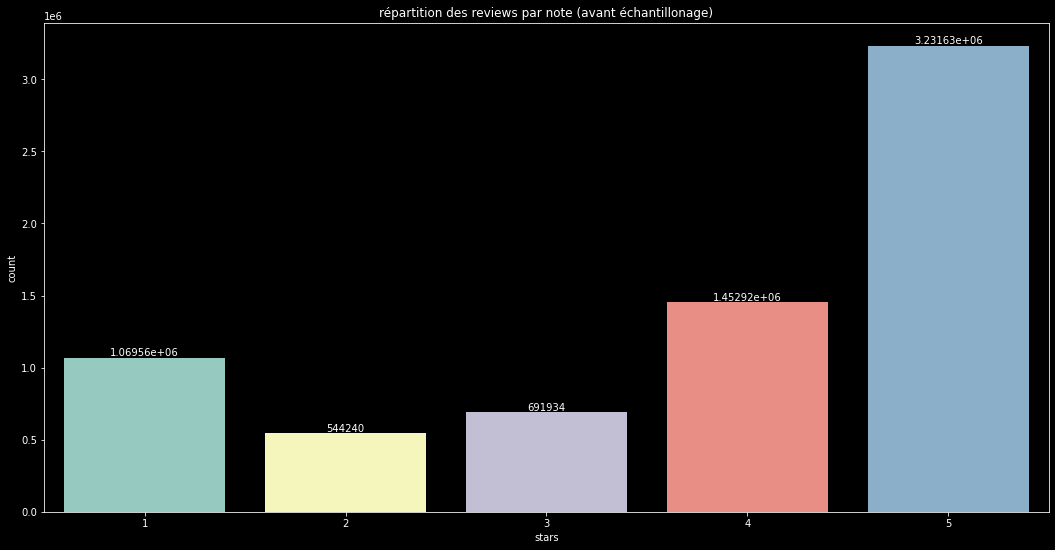

Récupération des reviews dont la note est inférieure à 3 étoiles...
{} mauvaises reviews récupérées
Echantillonage de 500 reviews...


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
2568433,8U6daSmNMOny1PwOWC8FpQ,xpcS0epAHzKNPV8IzAbpMg,iZ7-gwaBWYHiWhez4514jA,2,0,0,0,It's just an open food court with vendors who ...,2018-12-08 19:26:05
3008265,AWgtItZdrZOpCMDdq3YlIA,GW3igeE8GMps2_oPzDd33A,17MK8qagV374AuUA4sXuIA,2,0,0,0,What a shame. Nineteen is an absolutely beauti...,2017-12-25 03:52:00
782914,jkCXp5WamcV-iXPLCcW4Cw,cNBzJ1VEFKUolWSWg778Ow,KDALtmM8fy4dgpGjw5SzuA,1,0,0,0,Not a professional nail shop if you ask me. Te...,2018-07-28 21:08:09
4524269,EYf7RvSxqb4b_gAalhdHLA,C4HB6dIul13sb9ZW0LkLAg,aDB7LpvSsdfRA8gERB3cng,1,1,0,0,No thank you. Service is nothing special. Des...,2017-08-22 23:06:07
4260781,Vf9zMI1t6eGPb5q5V0gpSw,08FzsE7dBXHSqU77H0-Odg,LDA2LfI14CBOUZ-gZT6tZQ,1,1,0,0,"I love donuts, I had heard about this place an...",2015-05-03 13:05:27


Echantillonage OK. Nombre de reviews : 500


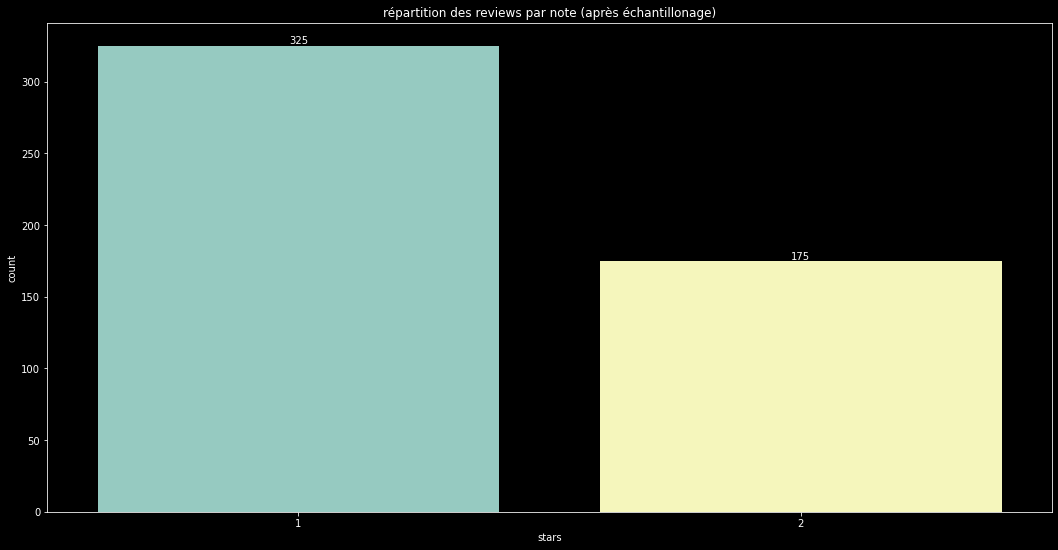

In [291]:
reviews = import_and_sample_bad_reviews(
    FILENAME_REVIEWS, 
    500, 
    plot=True, 
    verbose=True,
    random_state=1
)

Etant donné que nous ne nous en servirons pas dans cette analyse, nous allons supprimer les colonnes suivantes :
- review_id
- user_id
- business_id
- useful
- funny
- cool
- date

In [292]:
reviews.drop(
    columns = [
        "review_id",
        "user_id",
        "business_id",
        "useful",
        "funny",
        "cool",
        "date"
    ],
    inplace=True
)
reviews.head()

,stars,text
2568433,2,It's just an open food court with vendors who ...
3008265,2,What a shame. Nineteen is an absolutely beauti...
782914,1,Not a professional nail shop if you ask me. Te...
4524269,1,No thank you. Service is nothing special. Des...
4260781,1,"I love donuts, I had heard about this place an..."


## Détection des sujets d'insatisfaction

### Preprocessing

Dans un premier temps, nous allons :
- Convertir le texte en minuscule
- Supprimer les retours à la ligne
- Supprimer la ponctuation
- Supprimer les nombres

In [293]:
def clean_string(text):
    # conversion du texte en minuscules
    text = text.lower()
    # suppression des retours à la ligne
    text = re.sub(r'\n', '', text)
    # suppression de la ponctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    # suppression des nombres
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

def clean_reviews(reviews, verbose=False):
    if verbose:
        print("Nettoyage du texte des reviews...")
    reviews["text"] = reviews["text"].apply(clean_string)
    if verbose:
        print("Nettoyage OK")
        display(reviews.head())
    return reviews

In [294]:
reviews = clean_reviews(reviews, verbose=True)

Nettoyage du texte des reviews...
Nettoyage OK


,stars,text
2568433,2,its just an open food court with vendors who m...
3008265,2,what a shame nineteen is an absolutely beautif...
782914,1,not a professional nail shop if you ask me tec...
4524269,1,no thank you service is nothing special desig...
4260781,1,i love donuts i had heard about this place and...


### Tokenisation

Nous allons séparer les documents en tokens. Dans cette étape, le texte est divisé en unités plus petites, en l'occurence ici en mots

In [295]:
def tokenize_doc(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text_tokenized = tokenizer.tokenize(text)
    return text_tokenized

def tokenize_reviews(reviews, plot=False, verbose=False):
    if verbose:
        print("Tokenisation des documents...")
    reviews["text"] = reviews["text"].apply(tokenize_doc)
    if verbose:
        print("Tokenisation OK")
        display(reviews["text"].head())
    return reviews

In [296]:
reviews = tokenize_reviews(reviews, verbose=True)

Tokenisation des documents...
Tokenisation OK


2568433    [its, just, an, open, food, court, with, vendo...
3008265    [what, a, shame, nineteen, is, an, absolutely,...
782914     [not, a, professional, nail, shop, if, you, as...
4524269    [no, thank, you, service, is, nothing, special...
4260781    [i, love, donuts, i, had, heard, about, this, ...
Name: text, dtype: object

### Suppression des stopwords (mots vides)

Les mots vides sont les mots couramment utilisés et sont supprimés du texte car ils n'ajoutent aucune valeur à l'analyse. Ces mots ont peu ou pas de sens.

In [297]:
def remove_stopwords(text):
    nltk.download("stopwords", quiet=True)
    if type(text) == str:
        text = text.split()
    useless_words = stopwords.words("english")
    useless_words = useless_words + ['hi', 'im']
    text_filtered = [word for word in text if not word in useless_words]
    return text_filtered

In [298]:
reviews["text"] = reviews["text"].apply(remove_stopwords)
reviews.head()

,stars,text
2568433,2,"[open, food, court, vendors, might, students, ..."
3008265,2,"[shame, nineteen, absolutely, beautiful, resta..."
782914,1,"[professional, nail, shop, ask, technicians, p..."
4524269,1,"[thank, service, nothing, special, design, not..."
4260781,1,"[love, donuts, heard, place, thought, would, t..."


#### Lemmatisation

Nous allons préférer la lemmatisation à la radicalisation (stemming).
- Le **stemming** (radicalisation des mots) radicalise ou supprime simplement les derniers caractères d'un mot, ce qui conduit souvent à des significations et à une orthographe incorrecte.
- La **lemmatisation** considère le contexte et convertit le mot en sa forme de base significative, appelée lemme. Parfois, le même mot peut avoir plusieurs lemmes différents. Nos devons identifier la balise POS (Part of speech) du mot dans ce contexte spécifique.

Voici un exemple pour illustrer les différences entre ces deux traitements :
- Si on lemmatise le mot "**caring**", ça renverra "**care**", alors qu'un stemming renverra "**car**", ce qui est erroné.
- Si on lemmatize le mot "**stripes**" dans un contexte de **verbe**, il renverra "**strip**". Si on le lemmatise dans un contexte de **nom**, il renverra "**stripe**". Le stemming renverrait simplement "**strip**"

Néanmoins, la lemmatisation est coûteuse en calcul

In [299]:
def lemmatize_text(doc):
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    lemmatizer = WordNetLemmatizer()
    doc = [lemmatizer.lemmatize(token) for token in doc]
    return doc

In [300]:
reviews["text"] = reviews["text"].apply(lemmatize_text)
reviews.head()

,stars,text
2568433,2,"[open, food, court, vendor, might, student, in..."
3008265,2,"[shame, nineteen, absolutely, beautiful, resta..."
782914,1,"[professional, nail, shop, ask, technician, pl..."
4524269,1,"[thank, service, nothing, special, design, not..."
4260781,1,"[love, donut, heard, place, thought, would, tr..."


### Bigrammes

Les n-grams sont des séquences de mots. Les unigrams sont des mots uniques, bigrams des séquences de deux mots, trigrams de trois mots et ainsi de suite.
Nous allons ajouter à nos liste de mots les bigrammes qui apparaissent au moins 20 fois dans le corpus

In [301]:
def process_bigrams(reviews, column_name, min_bigram_count=20):
    docs = reviews[column_name].tolist()
    bigram = Phrases(
        docs, 
        min_count=min_bigram_count
    )
    for i in range(len(docs)):
        for token in bigram[docs[i]]:
            if '_' in token:
                docs[i].append(token)
    reviews[column_name] = docs
    return reviews

In [302]:
reviews = process_bigrams(reviews, "text", min_bigram_count=20)

### Suppression des mots trop rares ou trop communs

Nous allons supprimer les mots qui apparaissent trop ou trop peu dans le corpus

In [303]:
def filter_extremes(
    reviews, 
    column_name, 
    below, 
    above, 
    verbose=False
):
    docs = reviews[column_name].tolist()
    dictionary = Dictionary(docs)
    # suppression des mots qui apparaissent trop peu ou trop
    # dans le corpus
    dictionary.filter_extremes(no_below=below, no_above=above)
    # transformation du corpus en "bag of words"
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    if verbose:
        print("Nombre de documents : {}".format(len(corpus)))
        print("Nombre de tokens uniques : {}".format(len(dictionary)))
    return corpus, dictionary

In [304]:
corpus, dictionary = filter_extremes(
    reviews, 
    "text", 
    below=20, 
    above=0.5, 
    verbose=True
)

Nombre de documents : 500
Nombre de tokens uniques : 278


## Détection des thèmes principaux (topics) avec LDA

LDA est un modèle probabiliste qui permet d'extraire des composantes latentes du corpus : les topics.
Les documents comportent des topics latents, eux-même sont composés de mots. Ainsi, chaque topic est modélisé comme une distribution de mots, et chaque document comme un sensemble de topics distribués selon les lois de Dirichlet. L'algorithme utilisera ces données pour déterminer les paramètres des distributions en question

In [305]:
def get_coherence_perplexity(
    start, 
    stop, 
    step, 
    corpus, 
    dictionary, 
    documents,
    verbose=False
):
    coherence_scores=[]
    perplexity_scores=[]
    for num_topics in range(start, stop+1, step):
        if verbose:
            print("Calcul pour {} topics :".format(num_topics))
        model_lda = LdaModel(
            corpus=corpus, 
            num_topics=num_topics, 
            id2word=dictionary, 
            passes=2, 
            random_state=0
        )
        
        perplexity_score = model_lda.log_perplexity(corpus)
        perplexity_scores.append(perplexity_score)
        if verbose:
            print("Score de Perplexité : {}".format(round(perplexity_score, 3)))
        
        coherence_model = CoherenceModel(
            model=model_lda, 
            texts=documents, 
            dictionary=dictionary, 
            coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
        if verbose:
            print("Score de Cohérence = {}".format(round(coherence_score, 3)))
        
    return coherence_scores, perplexity_scores

def topics_wordclouds(model):
    for topic in range(model.num_topics):
        plt.figure(figsize=(10, 10))
        wc = WordCloud().fit_words(dict(model.show_topic(topic, 200)))
        plt.imshow(wc)
        plt.axis("off")
        plt.title("Sujet d'insatisfaction n°{}".format(str(topic+1)))
        plt.show()
    return

def get_perplexity_score(model, corpus):
    perplexity_score = model.log_perplexity(corpus)
    return perplexity_score

def get_coherence_score(model, reviews, dictionary):
    ls_reviews = reviews["text"].tolist()
    coherence = CoherenceModel(
        model=model, 
        texts=ls_reviews, 
        dictionary=dictionary, 
        coherence='c_v'
    )
    coherence_score = coherence.get_coherence()
    return coherence_score

## Création d'un corpus avec BOW

Pour chaque document, on compte le nombre de fois où un mot apparaît (sa fréquence)

Un corpus BOW contient :
- l'identifiant des mots (qui permet de le retrouver par son indice dans le dictionnaire)
- le nombre d'occurences de ces mots

In [306]:
def make_bow_corpus(dictionary, reviews):
    ls_reviews = reviews["text"].tolist()
    # création du bag of words
    bow_corpus = [dictionary.doc2bow(text) for text in ls_reviews]
    return bow_corpus

In [307]:
bow_corpus = make_bow_corpus(dictionary, reviews)

In [308]:
pickle.dump(bow_corpus, open(sav_path+dashboard_prefix+"bow_corpus", "wb"))

## LDA avec corpus BOW

#### Nombre de topics optimal

Pour commencer, essayons de déterminer le nombre de topics optimal pour notre modèle

In [309]:
coherence_scores_bow, perplexity_scores_bow = get_coherence_perplexity(
    3, 
    12, 
    1, 
    bow_corpus, 
    dictionary, 
    reviews["text"].tolist(),
    verbose=True
)

Calcul pour 3 topics :
Score de Perplexité : -5.555
Score de Cohérence = 0.263
Calcul pour 4 topics :
Score de Perplexité : -5.57
Score de Cohérence = 0.253
Calcul pour 5 topics :
Score de Perplexité : -5.608
Score de Cohérence = 0.279
Calcul pour 6 topics :
Score de Perplexité : -5.643
Score de Cohérence = 0.283
Calcul pour 7 topics :
Score de Perplexité : -5.678
Score de Cohérence = 0.266
Calcul pour 8 topics :
Score de Perplexité : -5.71
Score de Cohérence = 0.274
Calcul pour 9 topics :
Score de Perplexité : -5.74
Score de Cohérence = 0.274
Calcul pour 10 topics :
Score de Perplexité : -5.765
Score de Cohérence = 0.274
Calcul pour 11 topics :
Score de Perplexité : -5.803
Score de Cohérence = 0.269
Calcul pour 12 topics :
Score de Perplexité : -5.838
Score de Cohérence = 0.273


In [310]:
pickle.dump(coherence_scores_bow, open(sav_path+dashboard_prefix+"coherence_scores_bow", "wb"))
pickle.dump(perplexity_scores_bow, open(sav_path+dashboard_prefix+"perplexity_scores_bow", "wb"))

[Text(0.5, 1.0, 'Scores de perplexité en fonction du nombre de topics')]

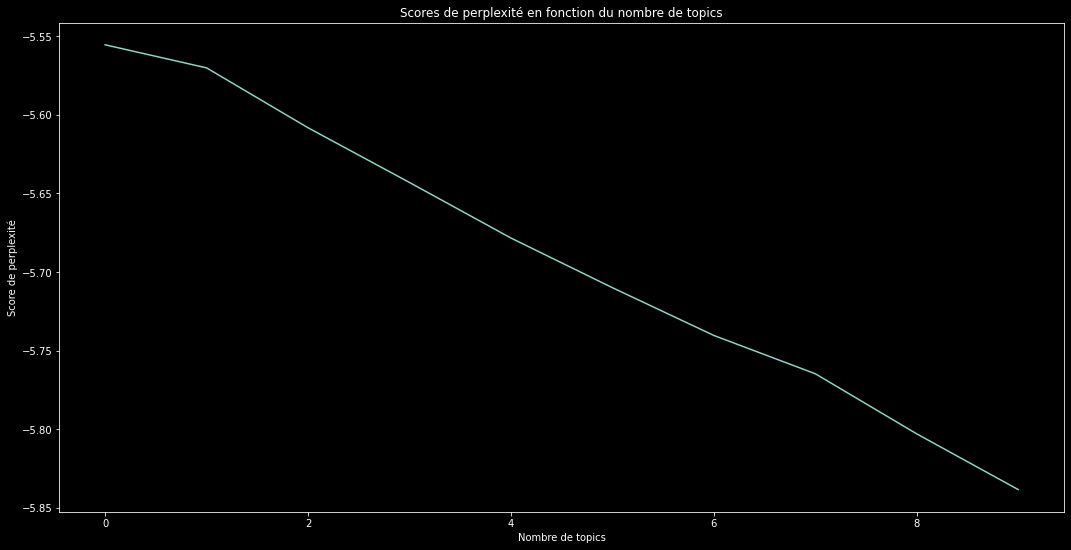

In [311]:
# à tracer dans le dashboard
plt.figure(figsize=(18,9))
nb_topics_bow = list(range(len(perplexity_scores_bow)))
max_perplexity_bow=max(perplexity_scores_bow)
idx_max_perplexity_bow = perplexity_scores_bow.index(max_perplexity_bow)
plt.xlabel("Nombre de topics")
plt.ylabel("Score de perplexité")
sns.lineplot(
    x=nb_topics_bow,
    y=perplexity_scores_bow
).set(title="Scores de perplexité en fonction du nombre de topics")

Text(3, 0.28251525823485607, 'max coherence : 0.28251525823485607 pour 3 topics')

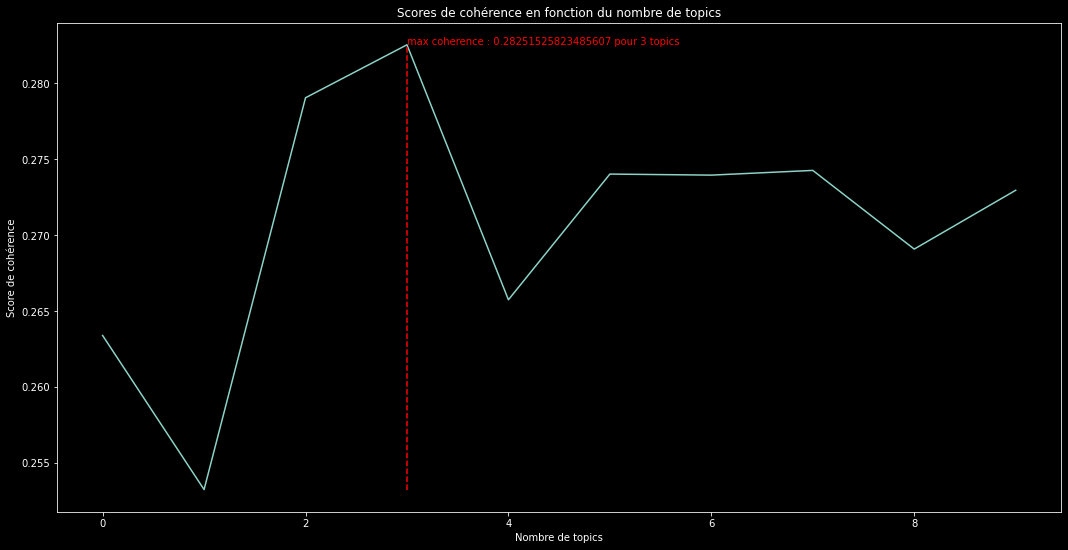

In [312]:
# à tracer dans le dashboard
plt.figure(figsize=(18,9))
nb_topics_bow = list(range(len(coherence_scores_bow)))
max_coherence_bow=max(coherence_scores_bow)
idx_max_coherence_bow = coherence_scores_bow.index(max_coherence_bow)
plt.xlabel("Nombre de topics")
plt.ylabel("Score de cohérence")
sns.lineplot(
    x=nb_topics_bow,
    y=coherence_scores_bow
).set(title="Scores de cohérence en fonction du nombre de topics")
plt.vlines(
    idx_max_coherence_bow,
    ymin=min(coherence_scores_bow),
    ymax=max_coherence_bow,
    color="#FF0000",
    linestyle="dashed"
)
plt.text(
    idx_max_coherence_bow,
    max_coherence_bow,
    "max coherence : {} pour {} topics".format(
        max_coherence_bow, 
        idx_max_coherence_bow
    ),
    color="#FF0000"
)

In [313]:
#############################
# paramètres d'entraînement #
#############################

# chunksize spécifie combien de documents sont traités en même temps
# pendant la phase d'entraînement de l'algorithme
chunksize = 60000
iterations = 400
num_topics = 3
passes = 20
eval_every = None # Nous n'évaluerons pas la perplexité du modèle (coûteux en temps de calcul)
tmp = dictionary[0] # charge le dictionnaire
id2word = dictionary.id2token

In [314]:
################
# Entraînement #
################

lda_bow = LdaModel(
    corpus=bow_corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every    
)

In [315]:
top_topics_bow = lda_bow.top_topics(bow_corpus)
# La cohérence thématique moyenne est 
# la somme des cohérences thématiques de tous les thèmes, 
# divisée par le nombre de thèmes.
average_coherence = sum([topic[1] for topic in top_topics])/num_topics
print("Cohérence moyenne de la thématique : {}".format(average_coherence))

Cohérence moyenne de la thématique : -1.5095178191204284


In [316]:
pickle.dump(lda_bow, open(sav_path+dashboard_prefix+"lda_bow", "wb"))
pickle.dump(top_topics_bow, open(sav_path+dashboard_prefix+"top_topics_bow", "wb"))

## Visualisation des topics

#### Wordclouds

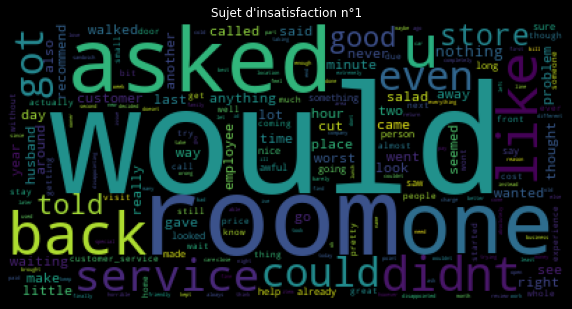

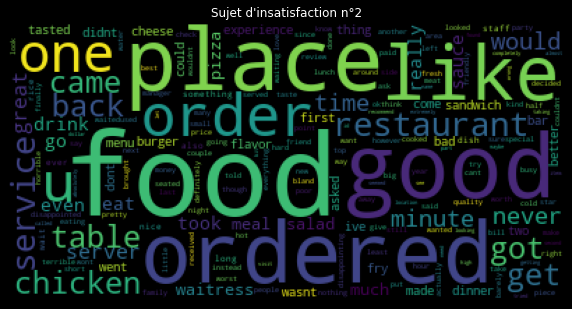

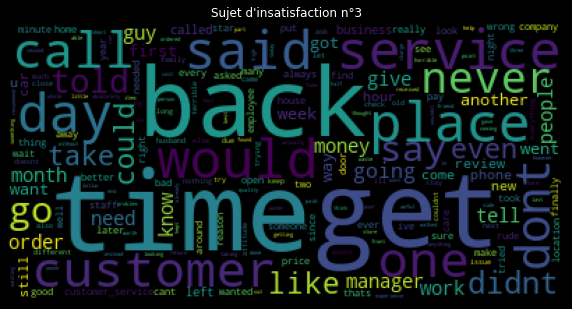

In [317]:
topics_wordclouds(lda_bow) # à tracer dans le dashboard

#### PyLDAvis

In [318]:
# à tracer dans le dashboard
pyLDAvis.enable_notebook()
p_bow = pyLDAvis.gensim_models.prepare(lda_bow, bow_corpus, dictionary)
p_bow

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.100652  0.004479       1        1  46.064390
2     -0.043487 -0.051685       2        1  38.793716
0     -0.057165  0.047205       3        1  15.141894, topic_info=                 Term        Freq       Total Category  logprob  loglift
4                food  271.000000  271.000000  Default  30.0000  30.0000
250              room   66.000000   66.000000  Default  29.0000  29.0000
14              would  204.000000  204.000000  Default  28.0000  28.0000
122             asked  119.000000  119.000000  Default  27.0000  27.0000
91                day  106.000000  106.000000  Default  26.0000  26.0000
117           ordered  147.000000  147.000000  Default  25.0000  25.0000
83                  u  174.000000  174.000000  Default  24.0000  24.0000
226             store   46.000000   46.000000  Default  23.0000  23.0000
89           customer   99.000000   99.000000  Default  22.0000  22.0000
128             didnt  141.000000  141.000000  Default  21.0000  21.0000
37                one  211.000000  211.000000  Default  20.0000  20.0000
147              call   86.000000   86.000000  Default  19.0000  19.0000
269             table   72.000000   72.000000  Default  18.0000  18.0000
229           chicken   80.000000   80.000000  Default  17.0000  17.0000
61               back  224.000000  224.000000  Default  16.0000  16.0000
126             could  129.000000  129.000000  Default  15.0000  15.0000
109              told  111.000000  111.000000  Default  14.0000  14.0000
193             salad   66.000000   66.000000  Default  13.0000  13.0000
22               good  199.000000  199.000000  Default  12.0000  12.0000
42            nothing   67.000000   67.000000  Default  11.0000  11.0000
78             server   63.000000   63.000000  Default  10.0000  10.0000
6                like  202.000000  202.000000  Default   9.0000   9.0000
39               even  144.000000  144.000000  Default   8.0000   8.0000
98                got  147.000000  147.000000  Default   7.0000   7.0000
27         restaurant   94.000000   94.000000  Default   6.0000   6.0000
102              said  130.000000  130.000000  Default   5.0000   5.0000
56               time  234.000000  234.000000  Default   4.0000   4.0000
227           waiting   45.000000   45.000000  Default   3.0000   3.0000
173          anything   37.000000   37.000000  Default   2.0000   2.0000
270          waitress   49.000000   49.000000  Default   1.0000   1.0000
269             table   71.818389   72.590925   Topic1  -4.5906   0.7644
270          waitress   48.958217   49.709864   Topic1  -4.9738   0.7599
78             server   62.626389   63.630203   Topic1  -4.7275   0.7592
123            burger   42.023485   42.750377   Topic1  -5.1265   0.7580
208              meal   47.807015   48.714535   Topic1  -4.9975   0.7563
133               fry   45.786966   46.726704   Topic1  -5.0407   0.7548
229           chicken   78.802423   80.505070   Topic1  -4.4978   0.7538
4                food  262.894831  271.443001   Topic1  -3.2930   0.7431
125            cooked   22.120211   22.853893   Topic1  -5.7682   0.7425
276             bland   24.028264   24.843654   Topic1  -5.6855   0.7418
245            seated   23.913067   24.841705   Topic1  -5.6903   0.7370
236             sauce   50.244984   52.613143   Topic1  -4.9478   0.7291
242            dinner   38.864528   40.730122   Topic1  -5.2046   0.7282
190            flavor   43.113418   45.636944   Topic1  -5.1009   0.7182
18              drink   57.720694   61.552709   Topic1  -4.8091   0.7109
164             pizza   47.327820   50.673624   Topic1  -5.0076   0.7068
27         restaurant   87.434503   94.350341   Topic1  -4.3938   0.6990
172              menu   44.984633   48.598802   Topic1  -5.0584   0.6979
272              rice   28.288213   30.785244   Topic1  -5.5223   0.6905
210            tasted   39.119452   4

In [319]:
# à tracer dans le dashboard
for idx, topic in lda_bow.print_topics(num_topics=-1, num_words=8):
    print("Topic: {}".format(idx, topic))
    print("Mots : {}".format(topic))

Topic: 0
Mots : 0.025*"would" + 0.025*"room" + 0.021*"asked" + 0.020*"one" + 0.019*"back" + 0.019*"u" + 0.017*"like" + 0.017*"didnt"
Topic: 1
Mots : 0.037*"food" + 0.020*"good" + 0.020*"place" + 0.019*"ordered" + 0.015*"like" + 0.015*"order" + 0.013*"u" + 0.013*"one"
Topic: 2
Mots : 0.025*"time" + 0.022*"get" + 0.018*"back" + 0.014*"service" + 0.014*"place" + 0.014*"day" + 0.014*"would" + 0.014*"said"


## Evaluation du modèle LDA

### Score de perplexité

In [320]:
perplexity_score_bow = get_perplexity_score(lda_bow, bow_corpus)
print("Score de perplexité : {}".format(round(perplexity_score_bow, 3)))

Score de perplexité : -5.417


In [321]:
pickle.dump(perplexity_score_bow, open(sav_path+dashboard_prefix+"perplexity_score_bow", "wb"))

### Score de cohérence

In [322]:
coherence_score_bow = get_coherence_score(lda_bow, reviews, dictionary)
print("Score de cohérence : {}".format(round(coherence_score_bow, 3)))

Score de cohérence : 0.299


In [323]:
pickle.dump(coherence_score_bow, open(sav_path+dashboard_prefix+"coherence_score_bow", "wb"))

## Représentation TF-IDF

Pour représenter notre corpus avec TF-IDF (Term Frequency - Inverse Term Frequency), on compte le nombre d'apparitions du mot dans le document, puis on le pondère par l'inverse du nombre d'apparitions du mot dans l'ensemble des documents. Cela permet d'accorder plus d'importance aux mots qui apparaissent fréquemment dans un document alors qu'ils apparaissent peu dans les autres. Quand c'est le cas, cela signifie qu'ils ont de l'importance dans le document dans lequel ils apparaissent

In [324]:
def make_tfidf_corpus(bow_corpus):
    tfidf = TfidfModel(bow_corpus, smartirs='ntc')
    tfidf_corpus = tfidf[bow_corpus]
    return tfidf_corpus

In [325]:
tfidf_corpus = make_tfidf_corpus(bow_corpus)

In [326]:
pickle.dump(tfidf_corpus, open(sav_path+dashboard_prefix+"tfidf_corpus", "wb"))

#### Nombre de topics optimal

Pour commencer, essayons de déterminer le nombre de topics optimal pour notre modèle

In [327]:
coherence_scores_tfidf, perplexity_scores_tfidf = get_coherence_perplexity(
    3, 
    12, 
    1, 
    tfidf_corpus, 
    dictionary, 
    reviews["text"].tolist(),
    verbose=True
)

Calcul pour 3 topics :
Score de Perplexité : -6.383
Score de Cohérence = 0.234
Calcul pour 4 topics :
Score de Perplexité : -6.613
Score de Cohérence = 0.289
Calcul pour 5 topics :
Score de Perplexité : -6.823
Score de Cohérence = 0.235
Calcul pour 6 topics :
Score de Perplexité : -7.075
Score de Cohérence = 0.268
Calcul pour 7 topics :
Score de Perplexité : -7.276
Score de Cohérence = 0.268
Calcul pour 8 topics :
Score de Perplexité : -7.443
Score de Cohérence = 0.25
Calcul pour 9 topics :
Score de Perplexité : -7.56
Score de Cohérence = 0.234
Calcul pour 10 topics :
Score de Perplexité : -7.833
Score de Cohérence = 0.237
Calcul pour 11 topics :
Score de Perplexité : -8.049
Score de Cohérence = 0.235
Calcul pour 12 topics :
Score de Perplexité : -8.204
Score de Cohérence = 0.256


In [328]:
pickle.dump(coherence_scores_tfidf, open(sav_path+dashboard_prefix+"coherence_scores_tfidf", "wb"))
pickle.dump(perplexity_scores_tfidf, open(sav_path+dashboard_prefix+"perplexity_scores_tfidf", "wb"))

[Text(0.5, 1.0, 'Scores de perplexité en fonction du nombre de topics')]

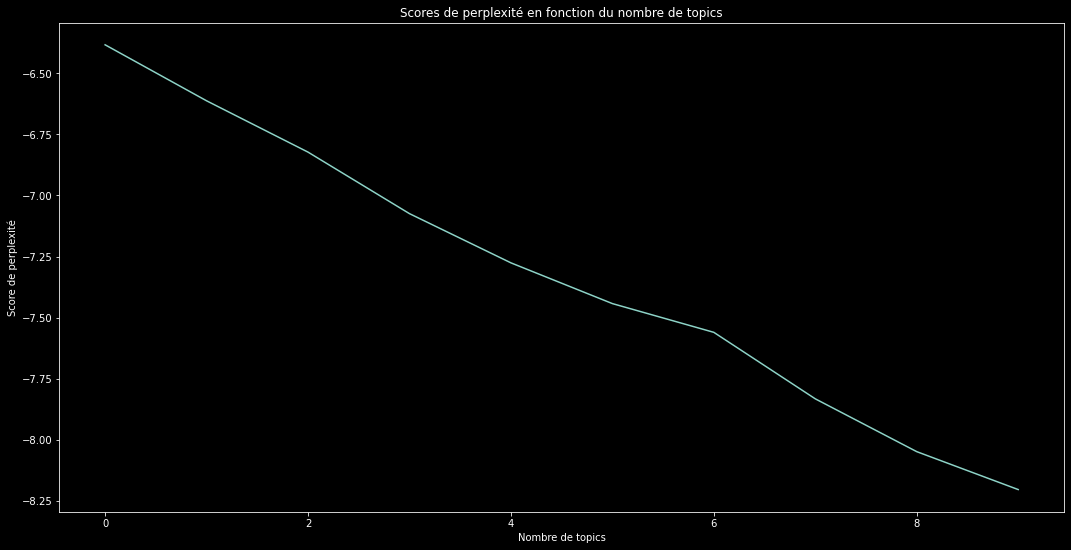

In [329]:
# à tracer dans le dashboard
plt.figure(figsize=(18,9))
nb_topics_tfidf = list(range(len(perplexity_scores_tfidf)))
max_perplexity_tfidf=max(perplexity_scores_tfidf)
idx_max_perplexity_tfidf = perplexity_scores_tfidf.index(max_perplexity_tfidf)
plt.xlabel("Nombre de topics")
plt.ylabel("Score de perplexité")
sns.lineplot(
    x=nb_topics_tfidf,
    y=perplexity_scores_tfidf
).set(title="Scores de perplexité en fonction du nombre de topics")

Text(1, 0.2885518465291566, 'max coherence : 0.2885518465291566 pour 1 topics')

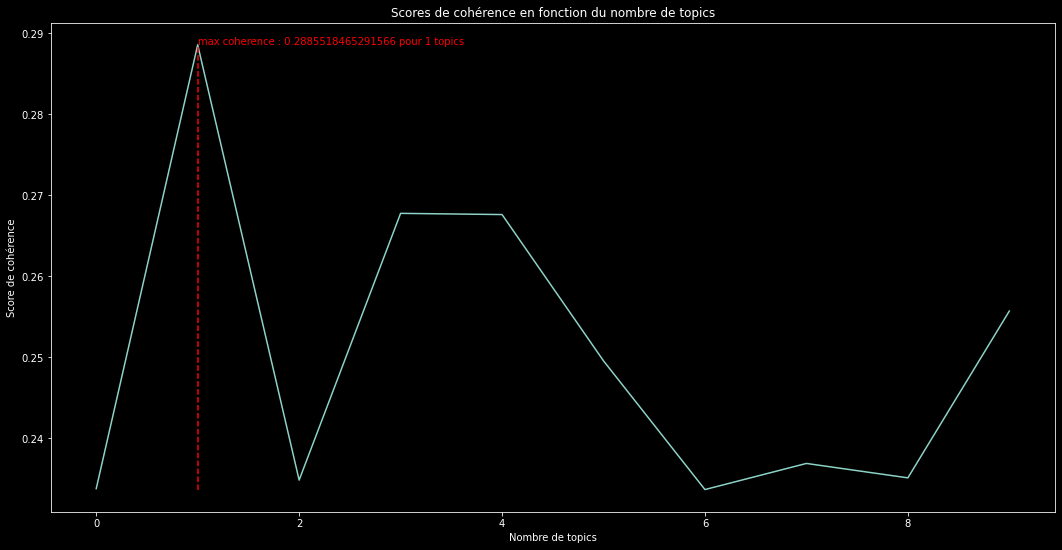

In [330]:
# à tracer dans le dashboard
plt.figure(figsize=(18,9))
nb_topics_tfidf = list(range(len(coherence_scores_tfidf)))
max_coherence_tfidf=max(coherence_scores_tfidf)
idx_max_coherence_tfidf = coherence_scores_tfidf.index(max_coherence_tfidf)
plt.xlabel("Nombre de topics")
plt.ylabel("Score de cohérence")
sns.lineplot(
    x=nb_topics_tfidf,
    y=coherence_scores_tfidf
).set(title="Scores de cohérence en fonction du nombre de topics")
plt.vlines(
    idx_max_coherence_tfidf,
    ymin=min(coherence_scores_tfidf),
    ymax=max_coherence_tfidf,
    color="#FF0000",
    linestyle="dashed"
)
plt.text(
    idx_max_coherence_tfidf,
    max_coherence_tfidf,
    "max coherence : {} pour {} topics".format(
        max_coherence_tfidf, 
        idx_max_coherence_tfidf
    ),
    color="#FF0000"
)

Avec un corpus TF-IDF, le score de cohérence maximum est atteint pour 1 topic. Néanmoins, afin de pouvoir comparer avec le modèle précédent, nous conserverons 3 topics, ce qui a tout de même le deuxième meilleur score de cohérence

In [331]:
#############################
# paramètres d'entraînement #
#############################

# chunksize spécifie combien de documents sont traités en même temps
# pendant la phase d'entraînement de l'algorithme
chunksize = 60000
iterations = 400
num_topics = 3
passes = 20
eval_every = None # Nous n'évaluerons pas la perplexité du modèle (coûteux en temps de calcul)
tmp = dictionary[0] # charge le dictionnaire
id2word = dictionary.id2token

In [332]:
################
# Entraînement #
################

lda_tfidf = LdaModel(
    corpus=tfidf_corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every    
)

In [333]:
top_topics_tfidf = lda_tfidf.top_topics(tfidf_corpus)
# La cohérence thématique moyenne est 
# la somme des cohérences thématiques de tous les thèmes, 
# divisée par le nombre de thèmes.
average_coherence = sum([topic[1] for topic in top_topics_tfidf])/num_topics
print("Cohérence moyenne de la thématique : {}".format(average_coherence))

Cohérence moyenne de la thématique : -2.181353280783609


In [334]:
pickle.dump(lda_tfidf, open(sav_path+dashboard_prefix+"lda_tfidf", "wb"))
pickle.dump(top_topics_tfidf, open(sav_path+dashboard_prefix+"top_topics_tfidf", "wb"))

## Visualisation des topics

#### Wordclouds

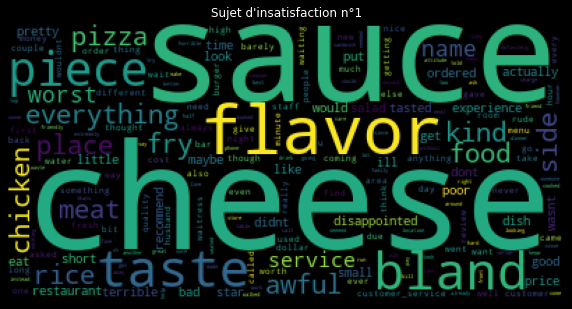

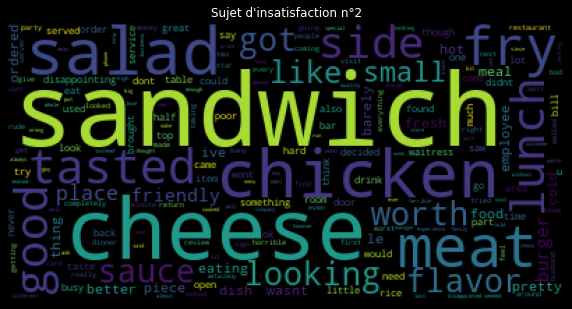

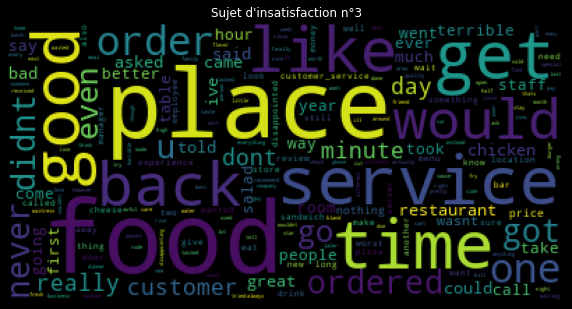

In [335]:
topics_wordclouds(lda_tfidf) # à tracer dans le dashboard

#### PyLDAvis

In [336]:

pyLDAvis.enable_notebook()
p_tfidf = pyLDAvis.gensim_models.prepare(lda_tfidf, tfidf_corpus, dictionary)
p_tfidf

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.011604 -0.000049       1        1  97.123581
1     -0.006220 -0.000993       2        1   1.686682
0     -0.005384  0.001041       3        1   1.189737, topic_info=              Term       Freq      Total Category  logprob  loglift
118       sandwich   8.000000   8.000000  Default  30.0000  30.0000
229        chicken  11.000000  11.000000  Default  29.0000  29.0000
22            good  16.000000  16.000000  Default  28.0000  28.0000
38           place  18.000000  18.000000  Default  27.0000  27.0000
4             food  20.000000  20.000000  Default  26.0000  26.0000
193          salad   9.000000   9.000000  Default  25.0000  25.0000
124         cheese   8.000000   8.000000  Default  24.0000  24.0000
6             like  15.000000  15.000000  Default  23.0000  23.0000
98             got  14.000000  14.000000  Default  22.0000  22.0000
12         service  17.000000  17.000000  Default  21.0000  21.0000
117        ordered  14.000000  14.000000  Default  20.0000  20.0000
56            time  17.000000  17.000000  Default  19.0000  19.0000
14           would  14.000000  14.000000  Default  18.0000  18.0000
61            back  15.000000  15.000000  Default  17.0000  17.0000
96             get  16.000000  16.000000  Default  16.0000  16.0000
37             one  14.000000  14.000000  Default  15.0000  15.0000
167          order  14.000000  14.000000  Default  14.0000  14.0000
72           never  14.000000  14.000000  Default  13.0000  13.0000
128          didnt  13.000000  13.000000  Default  12.0000  12.0000
83               u  14.000000  14.000000  Default  11.0000  11.0000
68            dont  12.000000  12.000000  Default  10.0000  10.0000
150             go  12.000000  12.000000  Default   9.0000   9.0000
39            even  12.000000  12.000000  Default   8.0000   8.0000
24          really  12.000000  12.000000  Default   7.0000   7.0000
89        customer  12.000000  12.000000  Default   6.0000   6.0000
70          minute  12.000000  12.000000  Default   5.0000   5.0000
5            great  11.000000  11.000000  Default   4.0000   4.0000
27      restaurant  11.000000  11.000000  Default   3.0000   3.0000
91             day  12.000000  12.000000  Default   2.0000   2.0000
234            bad  11.000000  11.000000  Default   1.0000   1.0000
4             food  20.372109  20.596171   Topic1  -4.5886   0.0182
38           place  18.681071  18.913497   Topic1  -4.6752   0.0168
12         service  17.203814  17.418702   Topic1  -4.7576   0.0168
56            time  16.866751  17.079703   Topic1  -4.7774   0.0166
96             get  16.224779  16.434521   Topic1  -4.8162   0.0163
167          order  14.751306  14.962727   Topic1  -4.9114   0.0150
37             one  14.741759  14.953419   Topic1  -4.9121   0.0149
61            back  14.985193  15.201209   Topic1  -4.8957   0.0149
14           would  14.777555  14.994924   Topic1  -4.9096   0.0146
6             like  15.609121  15.841603   Topic1  -4.8549   0.0144
22            good  16.210251  16.451800   Topic1  -4.8171   0.0144
72           never  14.197901  14.409908   Topic1  -4.9497   0.0144
83               u  13.877910  14.088138   Topic1  -4.9724   0.0142
117        ordered  14.544868  14.767702   Topic1  -4.9255   0.0140
128          didnt  13.328000  13.540172   Topic1  -5.0129   0.0134
39            even  12.735814  12.944859   Topic1  -5.0583   0.0129
150             go  12.734992  12.945956   Topic1  -5.0584   0.0128
89        customer  12.279617  12.487887   Topic1  -5.0948   0.0124
98             got  13.785771  14.020176   Topic1  -4.9791   0.0123
24          really  12.317793  12.527851   Topic1  -5.0917   0.0123
70          minute  12.199248  12.407793   Topic1  -5.1014   0.0122
91             day  11.919824  12.127567   Topic1  -5.1245   0.0119
68            dont  12.000851  12.218743   Topic1  -5.1178   0.0112
102           s

In [337]:
# à tracer dans le dashboard
for idx, topic in lda_tfidf.print_topics(num_topics=-1, num_words=8):
    print("Topic: {}".format(idx, topic))
    print("Mots : {}".format(topic))

Topic: 0
Mots : 0.004*"cheese" + 0.004*"sauce" + 0.004*"flavor" + 0.004*"taste" + 0.004*"bland" + 0.004*"piece" + 0.004*"everything" + 0.004*"kind"
Topic: 1
Mots : 0.011*"sandwich" + 0.007*"cheese" + 0.007*"chicken" + 0.006*"salad" + 0.005*"meat" + 0.005*"fry" + 0.005*"tasted" + 0.004*"lunch"
Topic: 2
Mots : 0.010*"food" + 0.009*"place" + 0.009*"service" + 0.008*"time" + 0.008*"get" + 0.008*"good" + 0.008*"like" + 0.007*"back"


Ce que nous pouvons noter ici, c'est que nous avons un grand topic, le topic 1, avec 30 termes qui reviennent dans 96.7% des documents, tandis que pour les deux autres topics, les termes les plus significatifs ne sont présents que dans à peine 1% des documents

## Evaluation du modèle LDA

### Score de perplexité

In [338]:
perplexity_score_tfidf = get_perplexity_score(lda_tfidf, tfidf_corpus)
print("Score de perplexité : {}".format(round(perplexity_score_tfidf, 3)))

Score de perplexité : -5.813


In [339]:
pickle.dump(perplexity_score_tfidf, open(sav_path+dashboard_prefix+"perplexity_score_tfidf", "wb"))

### Score de cohérence

In [340]:
coherence_score_tfidf = get_coherence_score(lda_tfidf, reviews, dictionary)
print("Score de cohérence : {}".format(round(coherence_score_tfidf, 3)))

Score de cohérence : 0.29


In [341]:
pickle.dump(coherence_score_tfidf, open(sav_path+dashboard_prefix+"coherence_score_tfidf", "wb"))

## Analyse de sentiments

In [367]:
def sentiment_analysis(sentences):
    sntcs = sentences.copy()
    subjectivity = []
    polarity = []
    for i in range(len(sntcs)):
        sntcs[i] = " ".join(sntcs[i])
#         display(sntcs[i])
        tb = TextBlob(sntcs[i])
        subjectivity.append(tb.sentiment.subjectivity)
        polarity.append(tb.sentiment.polarity)
    df = pd.DataFrame({
        "sentence": sentences,
        "subjectivity": subjectivity,
        "polarity": polarity
    })
#     display(df.head(100))
    fig = px.scatter(
        df, 
        x="subjectivity", 
        y="polarity", 
        hover_data=['sentence'],
        template="plotly_dark"
    )
    fig.show()

In [370]:
def get_polarity(text):
   return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [371]:
# à tracer dans le dashboard
reviews["polarity"] = reviews["text"].map(get_polarity)
reviews["subjectivity"] = reviews["text"].map(get_subjectivity)
fig = px.scatter(
    reviews, 
    y="subjectivity", 
    x="polarity", 
    hover_data=['text'],
    color="stars",
    template="plotly_dark",
    color_continuous_scale="turbo",
    title="Analyse de sentiment des reviews"
)
fig.show()

C:\Users\Utilisateur\anaconda3\envs\OC_P06\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\Utilisateur\anaconda3\envs\OC_P06\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [372]:
pickle.dump(reviews, open(sav_path+dashboard_prefix+"reviews", "wb"))